# SPY Forward Return Prediction & Trading Strategy

## Project Overview

This notebook implements a machine learning approach to predict SPY's forward 5-day returns and evaluates two trading strategies:

- **Strategy A (Baseline)**: Simple sign-based strategy using model predictions
- **Strategy B (Risk-Scaled)**: Volatility-scaled positions based on prediction confidence

## Methodology

1. **Feature Engineering**: Construct price-based and non-price features (momentum, volatility, VIX, interest rates, volume)
2. **Walk-Forward Validation**: Use time-series cross-validation to avoid look-ahead bias
3. **Model Training**: Ridge regression with standardized features
4. **Strategy Implementation**: Convert predictions to trading positions with transaction costs
5. **Performance Evaluation**: Compare strategies using Sharpe ratio and cumulative returns

---


## 1. Data Loading & Setup

Download SPY price data from Yahoo Finance starting from 2010-01-01.


In [127]:
import yfinance as yf
import pandas as pd


df = yf.download("SPY", start="2010-01-01", auto_adjust=True)

# For flattening columns if a MultiIndex is returned
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

df.columns = df.columns.str.lower()

df.head(), df.tail(), df.shape

[*********************100%***********************]  1 of 1 completed


(Price           close       high        low       open     volume
 Date                                                             
 2010-01-04  85.027954  85.072968  83.662465  84.307697  118944600
 2010-01-05  85.253036  85.290552  84.667828  84.975441  111579900
 2010-01-06  85.313072  85.523147  85.102998  85.170519  116074400
 2010-01-07  85.673203  85.778240  84.915429  85.155515  131091100
 2010-01-08  85.958313  85.995829  85.275571  85.448130  126402800,
 Price            close        high         low        open    volume
 Date                                                                
 2025-12-26  690.309998  691.659973  689.270020  690.640015  41613300
 2025-12-29  687.849976  689.200012  686.070007  687.539978  62559500
 2025-12-30  687.010010  688.559998  686.580017  687.450012  47160700
 2025-12-31  681.919983  687.359985  681.710022  687.140015  74144800
 2026-01-02  683.169983  686.869995  679.820007  685.710022  89310400,
 (4025, 5))

## 2. Target Variable Definition

**Goal**: Predict the forward 5-day return of SPY.

- `y[t]` = return from day `t` to day `t+5`
- Calculated as: `(close[t+5] - close[t]) / close[t]`
- The `.shift(-H)` ensures we're predicting future returns, not past ones


### 2.1 Validation Check

Verify that the target variable calculation is correct by manually computing returns.


In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error


pd.set_option("display.max_columns", 50)

In [129]:
# Defining variable of interest y (forward H-day return, H=5 in our case)
close = df["close"]  # converts (4022,1) DataFrame to a Series

df["ret_1d"] = close.pct_change()  # calculates next day return

H = 5  # looking 5 days ahead for the next 5 day return

df["y"] = close.pct_change(H).shift(-H)  # calculates future H-day return

In [130]:
H = 5
check = pd.DataFrame({"close": close, "y": df["y"]}).dropna().head(8).copy()
check["future_close_t+5"] = close.shift(-H).loc[check.index]
check["manual_y"] = (
    check["future_close_t+5"] / check["close"]
) - 1  # Checking if the manual calculation of y corresponds to that using "pct_change..."
check

,close,y,future_close_t+5,manual_y
Date,,,,
2010-01-04,85.027954,0.012353,86.078346,0.012353
2010-01-05,85.253036,0.000264,85.275543,0.000264
2010-01-06,85.313072,0.008003,85.995796,0.008003
2010-01-07,85.673203,0.006481,86.228409,0.006481
2010-01-08,85.958313,-0.008117,85.260582,-0.008117
2010-01-11,86.078346,0.002876,86.325920,0.002876
2010-01-12,85.275543,0.002024,85.448120,0.002024
2010-01-13,85.995796,-0.025475,83.805016,-0.025475


### 2.2 Exploratory Data Analysis (Target Variable)

Examine the distribution and volatility characteristics of forward 5-day returns.


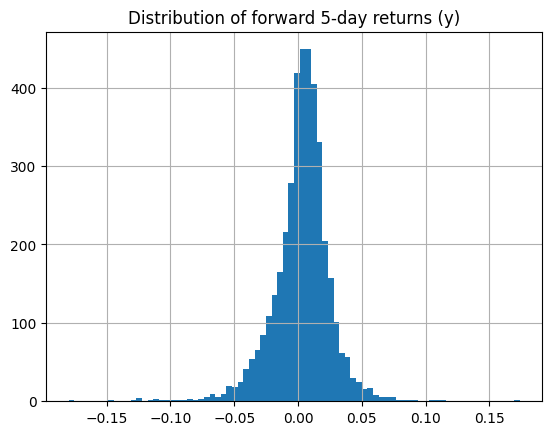

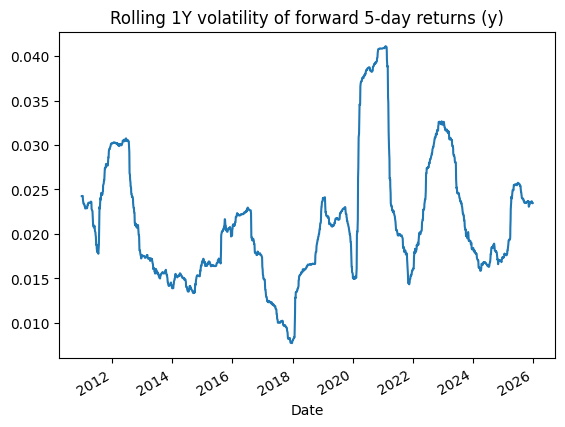

In [131]:
# EDA: How does y look?
import matplotlib.pyplot as plt

plt.figure()
df["y"].dropna().hist(bins=80)
plt.title("Distribution of forward 5-day returns (y)")
plt.show()

plt.figure()
df["y"].dropna().rolling(252).std().plot()
plt.title("Rolling 1Y volatility of forward 5-day returns (y)")
plt.show()

## 3. Feature Engineering

### 3.1 Price-Based Features

Construct technical indicators using only historical price data:

- **Momentum**: 5-day, 20-day, 60-day returns
- **Trend**: Ratio of 20-day to 60-day moving averages
- **Volatility**: 20-day rolling standard deviation of daily returns
- **Mean Reversion**: Z-score of price relative to 20-day rolling mean/std

**Important**: All features use only past data (via `.shift()`, `.rolling()`, `.pct_change()`) to prevent look-ahead bias.

In [132]:
# Feature engineering step

# Momentum
df["mom_5"] = close.pct_change(5)
df["mom_20"] = close.pct_change(20)
df["mom_60"] = close.pct_change(60)

# Moving averages
df["ma_20"] = close.rolling(20).mean()
df["ma_60"] = close.rolling(60).mean()
df["trend_20_60"] = (df["ma_20"] - df["ma_60"]) / df["ma_60"]

# Volatility
df["vol_20"] = df["ret_1d"].rolling(20).std()

# Mean reversion
roll_mean = close.rolling(20).mean()
roll_std = close.rolling(20).std()
df["z_20"] = (close - roll_mean) / roll_std

# We will include more non-price features after the baseline model is tested.

### 3.2 Non-Price Features

Add external market indicators to capture broader market conditions:

- **VIX Features**: Volatility index (risk regime indicator)
  - `vix_chg_5`: 5-day change in VIX
  - `vix_z_20`: Z-score of VIX relative to 20-day rolling statistics
  
- **Interest Rates**: 10-Year Treasury yield (TNX) as a macro regime indicator
  - `tnx_chg_5`: 5-day change in yield (using `.diff()` since yields are absolute levels)
  
- **Volume Features**: Trading volume patterns
  - `vol_chg_5`: 5-day percentage change in volume
  - `vol_z_20`: Z-score of volume relative to 20-day rolling statistics

These features help the model capture market regime changes and sentiment shifts.


In [133]:
# Include non-price features for the model


def download_close(ticker, start="2010-01-01"):
    tmp = yf.download(ticker, start=start, auto_adjust=True, progress=False)
    if isinstance(tmp.columns, pd.MultiIndex):
        tmp.columns = tmp.columns.get_level_values(0)
    tmp.columns = tmp.columns.str.lower()
    return tmp["close"]

In [134]:
# --- VIX (risk regime) ---
vix = download_close("^VIX", start="2010-01-01").reindex(df.index).ffill()
df["vix"] = vix
df["vix_chg_5"] = df["vix"].pct_change(5)
df["vix_z_20"] = (df["vix"] - df["vix"].rolling(20).mean()) / df["vix"].rolling(
    20
).std()

# --- 10Y yield proxy (rates regime) ---
tnx = download_close("^TNX", start="2010-01-01").reindex(df.index).ffill()
df["tnx"] = tnx
df["tnx_chg_5"] = df["tnx"].diff(5)  # yields: use difference, not pct_change

# --- Volume features (non-price) ---
df["vol_chg_5"] = df["volume"].pct_change(5)
df["vol_z_20"] = (df["volume"] - df["volume"].rolling(20).mean()) / df[
    "volume"
].rolling(20).std()

### 3.3 Data Cleaning & Feature Selection

- Select all engineered features (6 price-based + 5 non-price = 11 total features)
- Drop rows with NaN values (created by rolling windows and feature calculations)
- Separate features (X) from target variable (y)


In [135]:
# Cleaning the dataset to drop NaNs

feature_cols = [
    "mom_5",
    "mom_20",
    "mom_60",
    "trend_20_60",
    "vol_20",
    "z_20",
    "vix_chg_5",
    "vix_z_20",
    "tnx_chg_5",
    "vol_chg_5",
    "vol_z_20",
]

data = df[feature_cols + ["y"]].dropna()

X = data[feature_cols]
y = data["y"]
data.tail()

Price,mom_5,mom_20,mom_60,trend_20_60,vol_20,z_20,vix_chg_5,vix_z_20,tnx_chg_5,vol_chg_5,vol_z_20,y
Date,,,,,,,,,,,,
2025-12-18,-0.018428,0.020886,0.023249,0.007049,0.007590,-0.202036,0.136027,-0.239313,-0.025,0.260827,0.752578,0.023475
2025-12-19,0.001234,0.046084,0.037309,0.008668,0.006741,0.393426,-0.052732,-1.039996,-0.043,-0.084489,0.861347,0.010667
2025-12-22,0.008996,0.042219,0.037825,0.010107,0.006566,1.083552,-0.146667,-1.735078,-0.013,-0.234050,-0.498902,0.003183
2025-12-23,0.016384,0.031796,0.039647,0.011026,0.005897,1.659115,-0.150485,-1.893023,0.020,-0.468658,-0.670662,-0.008780
2025-12-24,0.031308,0.025777,0.039389,0.011660,0.005627,1.915905,-0.235528,-2.115922,-0.015,-0.643430,-1.598298,-0.010444


### 3.4 Feature Exploration

In [136]:
eda = df[feature_cols + ["y"]].dropna()

# Sanity: check feature variability (should not be all NaN or constant)
print(eda[feature_cols].describe().T[["mean", "std", "min", "max"]])

# Quick correlation check with target y
eda.corr(numeric_only=True)["y"].sort_values(ascending=False)

                 mean       std       min       max
Price                                              
mom_5        0.002846  0.022489 -0.179693  0.173582
mom_20       0.011345  0.041733 -0.309868  0.230725
mom_60       0.034069  0.064851 -0.301868  0.397892
trend_20_60  0.010615  0.025753 -0.158373  0.079115
vol_20       0.009265  0.005828  0.002010  0.058701
z_20         0.447168  1.254773 -3.793763  3.089462
vix_chg_5    0.012899  0.177139 -0.466691  2.129032
vix_z_20    -0.043781  1.213163 -2.879260  4.025962
tnx_chg_5    0.000360  0.116389 -0.589000  0.511000
vol_chg_5    0.087878  0.496329 -0.830793  5.414919
vol_z_20    -0.008138  1.063093 -2.463844  3.842396


Price
y              1.000000
vol_20         0.080961
vix_chg_5      0.047624
vix_z_20       0.025056
vol_chg_5      0.023096
vol_z_20       0.001852
tnx_chg_5     -0.046704
mom_20        -0.069729
z_20          -0.070595
mom_5         -0.087475
trend_20_60   -0.099026
mom_60        -0.119477
Name: y, dtype: float64

## 4. Model Training: Walk-Forward Validation

**Critical**: Use time-series cross-validation to prevent look-ahead bias.

- **TimeSeriesSplit**: Splits data chronologically (earlier data for training, later for testing)
- **Pipeline**: StandardScaler → Ridge Regression (L2 regularization, alpha=1.0)
- **Walk-Forward**: For each split, train on past data and predict on future data
- **Out-of-Sample**: All predictions are on the testing set

In [137]:
# Walk forward training (with Ridge Regression) and testing

tscv = TimeSeriesSplit(
    n_splits=8
)  # Splits data into 8 partitions, so that we can use earlier data for training and later ones for testing

model = Pipeline(
    [("scaler", StandardScaler()), ("ridge", Ridge(alpha=1.0))]
)  # Builds a pipeline model that standardizes the data (subtract mean, divide by SD), then uses ridge regression

pred = pd.Series(
    index=X.index, dtype=float
)  # Creates a series to store predictions for every date in X

# Loops through our time based splits, uses some for training, some for testing
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train = y.iloc[train_idx]

    model.fit(X_train, y_train)
    pred.iloc[test_idx] = model.predict(
        X_test
    )  # Populates our pred series with the predictions

# Align realized y with pred
out = pd.DataFrame({"y": y, "pred": pred}).dropna()
out.head()

,y,pred
Date,,
2011-12-27,0.009566,-0.019041
2011-12-28,0.025715,-0.013613
2011-12-29,0.012607,-0.010418
2011-12-30,0.020080,-0.005443
2012-01-03,0.012785,-0.003969


### 4.1 Model Performance: Prediction Quality

Evaluate how well the model predicts forward returns:
- **Information Coefficient (IC)**: Correlation between predictions and actual returns
- **Scatter Plot**: Visual check of prediction accuracy

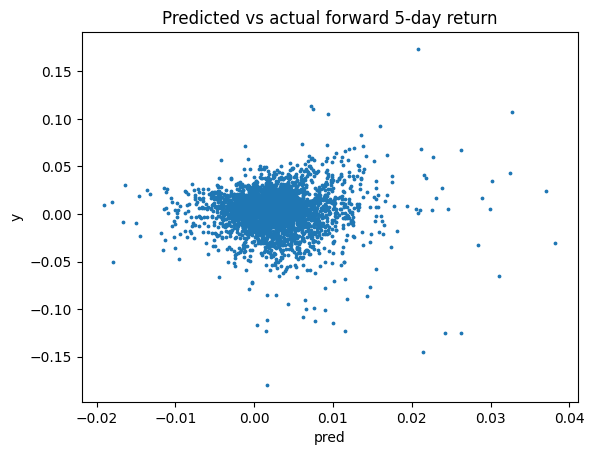

np.float64(0.03491297235602292)

In [138]:
# EDA: Predicted vs actual forward 5-day return
plt.figure()
plt.scatter(out["pred"], out["y"], s=3)
plt.title("Predicted vs actual forward 5-day return")
plt.xlabel("pred")
plt.ylabel("y")
plt.show()

ic = out["pred"].corr(out["y"])
ic

## 5. Trading Strategy Implementation

Convert model predictions into trading strategies with realistic transaction costs (5 bps per position change).

Baseline: Every day, use the model's prediction of SPY's forward 5-day return.
If the prediction is positive, go long; if negative, go short.

### 5.1 Strategy A: Baseline Sign-Based Strategy

**Logic**: 
- If prediction > 0 → Long position (+1)
- If prediction < 0 → Short position (-1)
- If prediction = 0 → No position (0)

**Characteristics**:
- Simple and intuitive
- High turnover (switches position on every sign change)
- Binary position sizing (always fully invested or fully short)

**Implementation**:
- Position = `sign(prediction)`
- Strategy return = `position[t-1] * actual_return[t] - transaction_cost * turnover`

In [139]:
out_simple = out.copy()
out_simple["pos"] = np.sign(out_simple["pred"])  # -1, 0, +1
out_simple["pos_prev"] = out_simple["pos"].shift(1).fillna(0.0)

tcost = 0.0005
out_simple["turnover"] = (out_simple["pos"] - out_simple["pos_prev"]).abs()
out_simple["strat_ret"] = (
    out_simple["pos_prev"] * out_simple["y"] - tcost * out_simple["turnover"]
)


def sharpe(r, periods=252):
    r = r.dropna()
    if r.std() == 0:
        return np.nan
    return np.sqrt(periods) * r.mean() / r.std()  # Annualized Sharpe ratio


sh_simple = sharpe(out_simple["strat_ret"])
sh_simple

np.float64(0.8961055334929436)

### 5.2 Strategy A: Turnover Analysis

Examine trading frequency and costs. High turnover can erode returns through transaction costs.

Simple strategy turnover:


count    3520.000000
mean        0.300852
std         0.714880
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: turnover, dtype: float64

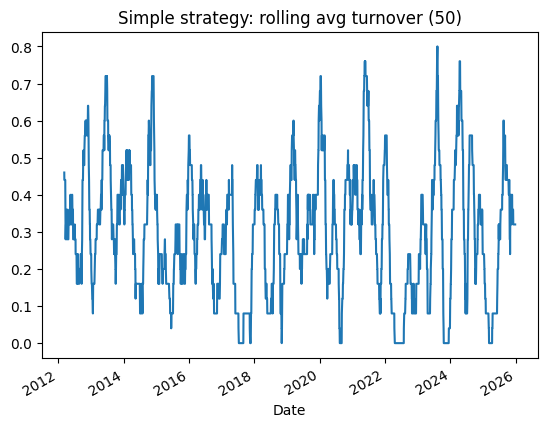

In [140]:
# EDA: Turnover check (Strategy A)
print("Simple strategy turnover:")
display(out_simple["turnover"].describe())

plt.figure()
out_simple["turnover"].rolling(50).mean().plot()
plt.title("Simple strategy: rolling avg turnover (50)")
plt.show()

### 5.3 Model Performance Metrics (Base Predictions)

Evaluate prediction quality before strategy implementation:
- **MSE**: Mean Squared Error (lower is better)
- **MAE**: Mean Absolute Error (lower is better)
- **IC**: Information Coefficient - correlation between predictions and actual returns (higher is better)

In [141]:
# Looking at the metrics to evaluate model performance

mse = mean_squared_error(out["y"], out["pred"])
mae = mean_absolute_error(out["y"], out["pred"])
ic = out["y"].corr(out["pred"])  # Information Coefficient

mse, mae, ic

(0.000483579178310678, 0.015474636733807202, np.float64(0.03491297235602292))

### 5.4 Strategy B: Risk-Scaled Strategy

**Logic**: Scale position size based on prediction confidence and volatility.

**Method**:
1. Calculate rolling 252-day (1 year) standard deviation of predictions
2. Normalize predictions by this volatility: `signal = prediction / rolling_std(prediction)`
3. Clip positions to [-1, 1] range

**Characteristics**:
- **Dynamic Position Sizing**: Larger positions when predictions are more confident/volatile
- **Risk Management**: Positions scale down during uncertain periods
- **Smoother Trading**: Less binary than Strategy A, potentially lower turnover

**Key Difference from Strategy A**: 
- Strategy A: Binary positions (-1, 0, +1)
- Strategy B: Continuous positions in [-1, 1] range, scaled by prediction volatility

**Note**: First 252 days have NaN for rolling std, filled with 0 (no position).

In [142]:
# Create separate DataFrame for Strategy B to avoid data confusion
out_scaled = out.copy()

# Use rolling standard deviations of predictions to scale risk
scale = out_scaled["pred"].rolling(252).std()
signal = (out_scaled["pred"] / scale).replace([np.inf, -np.inf], np.nan).fillna(0.0)

pos = signal.clip(-1, 1)  # position in [-1, 1]
out_scaled["pos"] = pos

### 5.5 Strategy B: Evaluation on Non-Overlapping Periods

Since we're predicting 5-day forward returns, we evaluate Strategy B on non-overlapping 5-day periods to avoid:
- Overlapping return calculations
- Double-counting the same prediction periods

This gives a more realistic assessment of strategy performance.


In [143]:
# Calculate trading costs - evals whether strategy is realistic
tcost = 0.0005  # 5 bps per 1.0 change in position (tweakable)

out_scaled["pos_prev"] = out_scaled["pos"].shift(1).fillna(0.0)
out_scaled["turnover"] = (out_scaled["pos"] - out_scaled["pos_prev"]).abs()
out_scaled["strat_ret"] = (
    out_scaled["pos_prev"] * out_scaled["y"] - tcost * out_scaled["turnover"]
)

In [144]:
# Evaluate Strategy B on non-overlapping 5-day periods
out5 = out_scaled.iloc[::5].copy()


def sharpe(r, periods):
    r = r.dropna()
    if r.std() == 0:
        return np.nan
    return np.sqrt(periods) * r.mean() / r.std()  # Calculates annualized Sharpe ratio


sh5 = sharpe(out5["strat_ret"], periods=252 / 5)
bh5 = sharpe(out5["y"], periods=252 / 5)

sh5, bh5

(np.float64(0.47464654225185676), np.float64(0.975841511468617))

### 5.6 Strategy B: Performance Summary

Compare Strategy B performance metrics against buy-and-hold benchmark.

In [145]:
mse = mean_squared_error(out["y"], out["pred"])
mae = mean_absolute_error(out["y"], out["pred"])
ic = out["pred"].corr(out["y"])

print("MSE:", mse)
print("MAE:", mae)
print("IC:", ic)
print("Strategy Sharpe (out5):", sh5)
print("BuyHold Sharpe (out5):", bh5)

MSE: 0.000483579178310678
MAE: 0.015474636733807202
IC: 0.03491297235602292
Strategy Sharpe (out5): 0.47464654225185676
BuyHold Sharpe (out5): 0.975841511468617


In [146]:
out5[["strat_ret", "y"]].describe()

,strat_ret,y
count,704.000000,704.000000
mean,0.001194,0.003008
std,0.017855,0.021880
min,-0.145458,-0.145458
25%,-0.003776,-0.006582
50%,0.000000,0.005076
75%,0.006913,0.014701
max,0.110681,0.110681


### 5.7 Strategy B: Cumulative Returns Visualization

Plot cumulative returns to visualize strategy performance over time compared to buy-and-hold.

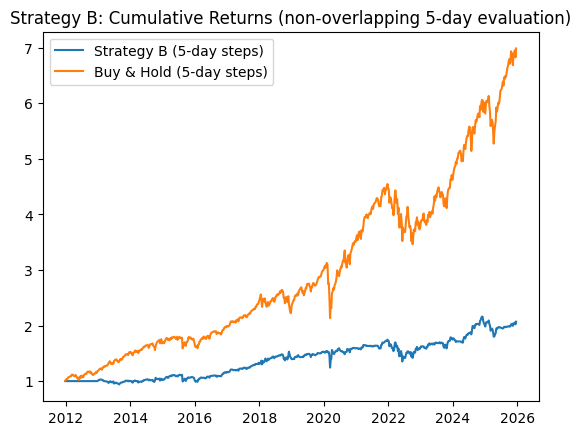

In [147]:
out5["cum_strat"] = (1 + out5["strat_ret"]).cumprod()
out5["cum_bh"] = (1 + out5["y"]).cumprod()

plt.figure()
plt.plot(out5.index, out5["cum_strat"], label="Strategy B (5-day steps)")
plt.plot(out5.index, out5["cum_bh"], label="Buy & Hold (5-day steps)")
plt.legend()
plt.title("Strategy B: Cumulative Returns (non-overlapping 5-day evaluation)")
plt.show()

Summary: predict SPY’s forward 5-day return using regression.

Pipeline:

1. Construct features using only past data (momentum, trend, volatility, mean reversion and non-price features).

2. Use time-series cross-validation (walk-forward) to avoid look-ahead bias when training the model.

3. Generate out-of-sample predictions

4. Convert predictions into a trading position (pos) and compute strategy returns (for main strategy, strategy B) after transaction costs.

5. Evaluate using Sharpe ratio and equity curve against buy-and-hold.
